In [ ]:
section .data
    error_argc db "Usage: ./program input_file output_file K", 10, 0
    error_open_input db "Error: Cannot open input file", 10, 0
    error_open_output db "Error: Cannot open output file", 10, 0
    error_k_value db "Error: K must be positive integer", 10, 0
    newline db 10, 0
    
section .bss
    input_fd resq 1
    output_fd resq 1
    buffer resb 1024
    k_value resq 1
    current_pos resq 1
    char_buffer resb 1
    
section .text
    global _start

_start:

    pop rcx
    cmp rcx, 4
    jne error_arguments
    
    pop rdi
    
    
    pop rdi
    
    
    mov rax, 2          ; sys_open
    mov rsi, 0          ; O_RDONLY
    mov rdx, 0          ; mode
    syscall
    
    cmp rax, 0
    jl error_open_input_file
    mov [input_fd], rax
    
  
    pop rdi
    
    
    mov rax, 2          
    mov rsi, 0x41       
    mov rdx, 0644o      
    syscall
    
    cmp rax, 0
    jl error_open_output_file
    mov [output_fd], rax
    

    pop rdi
    call string_to_int
    cmp rax, 0
    jle error_k_value_invalid
    mov [k_value], rax
    

    mov qword [current_pos], 0
    
read_loop:
    mov rax, 0          ; sys_read
    mov rdi, [input_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    
    cmp rax, 0
    jle exit_program    
    
    mov rax, [current_pos]
    inc qword [current_pos]
    xor rdx, rdx
    div qword [k_value] ; rax = current_pos / k_value, rdx = current_pos % k_value
    
    
    cmp rdx, 0
    jne read_loop
    
   
    mov rax, 1          ; sys_write
    mov rdi, [output_fd]
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    
    jmp read_loop

exit_program:
    ; Закрываем файлы
    mov rax, 3          ; sys_close
    mov rdi, [input_fd]
    syscall
    
    mov rax, 3          ; sys_close
    mov rdi, [output_fd]
    syscall
    
    mov rax, 60         ; sys_exit
    mov rdi, 0
    syscall


string_to_int:
    xor rax, rax        
    xor rcx, rcx        
    
convert_loop:
    movzx rdx, byte [rdi + rcx]
    cmp rdx, 0
    je done_convert
    cmp rdx, '0'
    jb done_convert
    cmp rdx, '9'
    ja done_convert
    
    sub rdx, '0'        
    imul rax, 10        
    add rax, rdx        
    
    inc rcx
    jmp convert_loop
    
done_convert:
    ret


write_error:
    push rcx
    push rdx
    
    
    mov rdx, rsi
find_length:
    cmp byte [rdx], 0
    je found_error_length
    inc rdx
    jmp find_length
    
found_error_length:
    sub rdx, rsi        
    
    mov rax, 1          ; sys_write
    mov rdi, 2          ; stderr
    syscall
    
    pop rdx
    pop rcx
    ret


error_arguments:
    mov rsi, error_argc
    call write_error
    jmp exit_error

error_open_input_file:
    mov rsi, error_open_input
    call write_error
    jmp exit_error

error_open_output_file:
    mov rsi, error_open_output
    call write_error
    jmp exit_error

error_k_value_invalid:
    mov rsi, error_k_value
    call write_error

exit_error:
    mov rax, 60         ; sys_exit
    mov rdi, 1
    syscall

![alt text](image.png)

In [ ]:
section .data
    error_argc db "Usage: ./program input_file output_file", 10, 0
    error_open_input db "Error: Cannot open input file", 10, 0
    error_open_output db "Error: Cannot open output file", 10, 0
    space db " ", 0
    newline db 10, 0
    
section .bss
    input_fd resq 1
    output_fd resq 1
    buffer resb 1024
    number_buffer resb 32
    in_number resb 1
    
section .text
    global _start

_start:
    pop rcx
    cmp rcx, 3
    jne error_arguments

    pop rdi
    
    pop rdi
 
    mov rax, 2          ; sys_open
    mov rsi, 0          ; O_RDONLY
    mov rdx, 0          ; mode
    syscall
    
    cmp rax, 0
    jl error_open_input_file
    mov [input_fd], rax
    
    pop rdi

    mov rax, 2          ; sys_open
    mov rsi, 0x41       ; O_CREAT | O_WRONLY | O_TRUNC
    mov rdx, 0644o      
    syscall
    
    cmp rax, 0
    jl error_open_output_file
    mov [output_fd], rax
    
    mov byte [in_number], 0
    
read_loop:
    mov rax, 0          ; sys_read
    mov rdi, [input_fd]
    mov rsi, buffer
    mov rdx, 1024
    syscall
    
    cmp rax, 0
    jle process_final_number 
    
    mov rcx, rax        
    mov rsi, buffer
    
process_buffer:
    mov al, [rsi]
    
    ; Проверяем цифру (0-9)
    cmp al, '0'
    jb not_digit
    cmp al, '9'
    ja not_digit

    call add_to_number
    jmp next_char
    
not_digit:
    cmp byte [in_number], 1
    jne next_char
  
    call finish_number
    
next_char:
    inc rsi
    loop process_buffer
    jmp read_loop

process_final_number:
    cmp byte [in_number], 1
    jne exit_program
    call finish_number

exit_program:
    mov rax, 3          ; sys_close
    mov rdi, [input_fd]
    syscall
    
    mov rax, 3          ; sys_close
    mov rdi, [output_fd]
    syscall
    
    mov rax, 60         ; sys_exit
    mov rdi, 0
    syscall

add_to_number:
    push rsi
    push rcx
    
    mov rdi, number_buffer
    cmp byte [in_number], 0
    je .first_digit
    
.find_end:
    cmp byte [rdi], 0
    je .add_digit
    inc rdi
    jmp .find_end
    
.first_digit:
    mov byte [in_number], 1
    
.add_digit:
    mov [rdi], al
    inc rdi
    mov byte [rdi], 0  
    
    pop rcx
    pop rsi
    ret

finish_number:
    push rsi
    push rcx
    
    cmp byte [number_buffer], 0
    je .done
    
    mov rdi, [output_fd]
    mov rsi, number_buffer
    call write_string
    
    mov rdi, [output_fd]
    mov rsi, space
    call write_string
    
    mov rdi, number_buffer
    mov rcx, 32
    xor al, al
    rep stosb
    
.done:
    mov byte [in_number], 0
    pop rcx
    pop rsi
    ret

write_string:
    push rcx
    push rdx
    push rsi

    mov rdx, rsi
.find_length:
    cmp byte [rdx], 0
    je .found_length
    inc rdx
    jmp .find_length
    
.found_length:
    sub rdx, rsi        
    mov rax, 1          ; sys_write

    syscall
    
    pop rsi
    pop rdx
    pop rcx
    ret


write_error:
    push rcx
    push rdx
    
    mov rdx, rsi
.find_error_length:
    cmp byte [rdx], 0
    je .found_error_length
    inc rdx
    jmp .find_error_length
    
.found_error_length:
    sub rdx, rsi        
    
    mov rax, 1          ; sys_write
    mov rdi, 2          ; stderr
    syscall
    
    pop rdx
    pop rcx
    ret

error_arguments:
    mov rsi, error_argc
    call write_error
    jmp exit_error

error_open_input_file:
    mov rsi, error_open_input
    call write_error
    jmp exit_error

error_open_output_file:
    mov rsi, error_open_output
    call write_error
    jmp exit_error

exit_error:
    mov rax, 60         ; sys_exit
    mov rdi, 1
    syscall

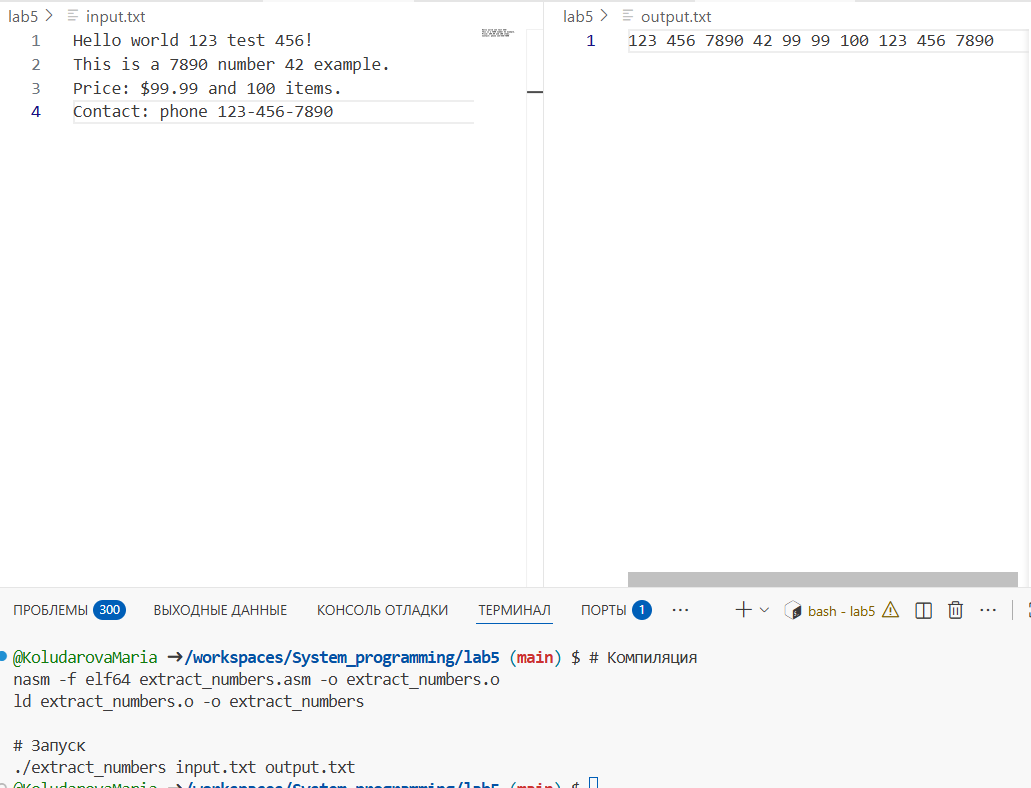